# Repressor-DNA binding energy Bayesian inference.

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [1]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special
import statsmodels.tools.numdiff as smnd # to compute the Hessian matrix

# Import custom utilities
sys.path.insert(0, '../') # add path to where the utils are located.
import mwc_mutants_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

#### Latex Macros
$\newcommand{\foldchange}{\text{fold-change}}$
$\newcommand{\foldchangethry}{\text{fold-change}_{\text{theory}}}$
$\newcommand{\Nns}{N_{NS}}$
$\newcommand{\eai}{\Delta\varepsilon_{AI}}$
$\newcommand{\era}{\Delta\varepsilon_{RA}}$
$\newcommand{\L}{\mathcal{L}}$

# Bayesian parameter inference for the repressor-DNA binding energy.

In this notebook we address the problem of fitting the repressor-DNA binding energy given the transcription factor titration data. Recall that the equation for fold-change is given by
$$
\foldchange = \left( 1 + p_{act}(c) {R \over \Nns} e^{-\beta \era} \right)^{-1},
\tag{1}
$$
where $p_{act}(c)$ is the probability of the repressor being in the active state as a function of the ligand concentration $c$, $R$ is the repressor copy number per cell, $\Nns$ is the number of non-specific binding sites in the genome where the repressor can bind, $\beta \equiv {1\over k_BT}$, and $\era$ is the parameter of interest, i.e. the repressor-DNA binding energy, hereafter referenced as the binding energy.

In the absence of ligand we can assume that $p_{act}(c) \approx 1$. Therefore upon varying the number of repressors $R$ we can infer the binding energy $\era$. To this purpose we constructed strains with varying number of repressors per cell, and we measured the fold-change in gene expression. In this notebook we will use a Bayesian approach to determine the probability distribution of this parameter given the experimental data.

## Defining Bayes theorem for this inference problem.

Let $D = \{d_1, d_2,\ldots,d_n\}$ be the data set of $n$ data points consisting of $x-y$ pairs of $R$ vs $\foldchange$. Then using Bayes theorem we can write the so-called posterior probability of the binding energy as
$$
P(\era \mid D) = {P(D \mid \era) P(\era) \over P(D)}.
\tag{2}
$$
The term $P(D \mid \era)$ represents the **likelihood** of having observed the data given a parameter value. $P(\era)$ represents the **prior** information we have about the parameter before performing the experiment. Finally $P(D)$ is a normalization constant that we will ignore since it does not depend on the parameter of interest.

### Choosing a likelihood function.

The first thing we assume is that each of the datum is independent of all the other data points. That means that we can write
$$
P(D \mid \era) = \prod_{i \in D} P(d_i \mid \era).
\tag{3}
$$
We then assume that the experimental fold-change $\foldchange _{\exp}$ is given by
$$
\foldchange_{\exp} = \foldchangethry + e,
\tag{4}
$$
where $\foldchangethry$ is given by Eq. 1 and $e \sim \mathcal{N}(0,\sigma)$ is a deviation from the theoretical prediction that we choose to have a mean zero and standard deviation $\sigma$. This selection allow us to write a Gaussian likelihood of the form
$$
\prod_{i \in D} P(d_i \mid \era, \sigma) = 
\prod_{i \in D} {1 \over \sqrt{2 \pi \sigma^2}}
\exp \left[{\left(\foldchange_{\exp}^{(i)} - \foldchangethry^{(i)}\right)^2 \over 2\sigma^2} \right].
\tag{5}
$$
Note that we added the nuisance parameter $\sigma$ to the equation.

### Choosing a prior function.

Since we now have two parameters $\era$ and $\sigma$ the first assumption we make is to say that both parameters have independent priors. This translates into writing
$$
P(\era, \sigma) = P(\era)P(\sigma).
\tag{6}
$$

Since the binding energies can take any real-number value we assign a uniform prior of the form
$$
P(\era) = {1 \over \era ^{\max} - \era ^{\min}},
\tag{7}
$$
where $\era ^{\max}$ and $\era ^{\min}$ set the boundaries of the values this parameter can take. For the standard deviation $\sigma$ we assign a so-called Jeffreys' prior of the form
$$
P(\sigma)\propto {1 \over \sigma}.
\tag{8}
$$

### Computing the posterior.

Putting all these terms together, and throwing all the constant terms to the proportionality constant we find that the posterior is given by
$$
P(\era, \sigma \mid D) \propto {1 \over \sigma^{n+1}} \prod_{i \in D} 
\exp \left[{\left(\foldchange_{\exp}^{(i)} - \foldchangethry^{(i)}\right)^2 \over 2\sigma^2} \right].
\tag{9}
$$

To remove the nuisance parameter $\sigma$ we can integrate it out. This is commonly known as marginalization and it is computed as
$$
P(\era) = \int d\sigma\; P(\era, \sigma).
\tag{10}
$$

The result of this integral gives a student-t distribution of the form
$$
P(\era) \propto \left[\sum_{i\in D} \left(\foldchange_{\exp}^{(i)} - \foldchangethry^{(i)}\right)^2 \right]^{n \over 2}.
\tag{11}
$$

This is the expression we will use to infer the binding energies given our experimental data.

First let's define a function to compute the theoretical fold-change for the case where there is zero inducer.

In [2]:
def fold_change(R, epsilon_ra, Nns=4.6E6):
    '''
    Computes the theoretical fold-change for a simple repression architecture
    in the absence of inducer.
    Parameters
    ----------
    R : array-like.
        Repressor copy number per cell.
    epsilon_ra : array-like.
        Repressor-DNA binding energy in units of kBT.
    Nns : int.
        Number of non-specific binding sites where the repressor can bind.
    Returns
    -------
    Theoretical fold-change.
    '''
    return (1 + R / Nns * np.exp(-epsilon_ra))**-1

Now let's define the log-posterior function given a set of experimental fold-change values paired with a list of repressor copy numbers and a given binding energy.

In [3]:
def log_post_epsilon_ra(epsilon_ra, data):
    '''
    Computes the unormalized log posterior for the repressor-DNA binding energy 
    given a Gaussian likelihood and a uniform prior for the binding energy.
    Parameters
    ----------
    epsilon_ra : float.
        Repressor-DNA binding energy to be evaluated in units of kBT.
    data : array-like, shape n x 2
        data[:, 0] : experimental fold-change values.
        data[:, 1] : associated repressor copy numbers.
    Returns
    -------
    non-normalized log-posterior probability.
    '''
    # Unpack variables
    fc_exp, R = data[:,0] , data[:,1]
    
    # Compute theoretical fold-change
    fc_thry = fold_change(R, epsilon_ra)
    
    # Compute the log-posterior
    return -len(R) / 2 * np.log(np.sum((fc_exp - fc_thry)**2))

# Fitting binding energies from experimental data.

With these functions in hand we can go ahead and fit the binding energies for the experimental data. First let's read the repressor titration data.

In [69]:
# Read the data
df = pd.read_csv('../../data/flow_lacI_master.csv', index_col=0)
# Remove the auto and delta values
# df.dropna(inplace=True)
df = df[(df.operator == 'O1')]
df = df[(df.strain != 'auto') & (df.strain != 'delta')]
df.head()

,date,username,operator,mut_class,strain,repressors,IPTG_uM,mean_YFP,mean_YFP_bgcorr,fold_change
6,20170613,sbarnes,O1,dna,Q21A,1220,0.0,3698.227366,550.950968,0.060901
7,20170613,sbarnes,O1,dna,Q21M,1220,0.0,3172.433487,25.157089,0.002781
8,20170613,sbarnes,O1,dna,Y20I,1220,0.0,3816.097131,668.820733,0.073931
9,20170613,sbarnes,O1,dna,Q21A,124,0.0,4841.786688,1694.510290,0.187309
10,20170613,sbarnes,O1,dna,Q21M,124,0.0,3191.508173,44.231775,0.004889


Now let's set a range of binding energies on which to evaluate the log-posterior and let's evaluate it for each of the DNA binding-domain mutants.

In [70]:
# Define binding energies to evaluate
epsilon_array = np.linspace(0, -17, 500)

# Group data by operator and binding mutant
df_group = df.groupby(['operator', 'strain'])

# Initialize array to save the log-posterior value for each 
# proposed binding energy
log_posterior = np.zeros([len(epsilon_array), len(df_group)])

# Initialize counter
j = 0
# Loop through each of the groups and compute the log-posterior for each strain
for group, data in df_group:
    print(group)
    # Extract the fold-change and repressor copy number from the data
    data_exp = data[['fold_change', 'repressors']].values
    # Loop through the epsilon values to evaluate the log posterior
    for i, eps in enumerate(epsilon_array):
        log_posterior[i, j] = log_post_epsilon_ra(epsilon_ra=eps, data=data_exp)
    
    # Set it to scale better
    log_posterior[:, j] -= np.max(log_posterior[:, j])
    # increase counter
    j += 1

('O1', 'Q21A')
('O1', 'Q21M')
('O1', 'Y20I')


Let's now plot the posterior probabilities for each of the mutants

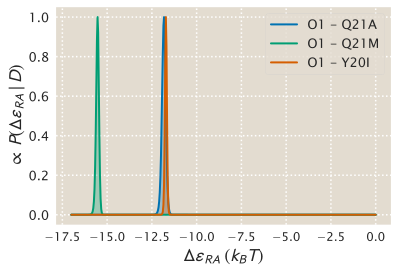

In [8]:
# Initialize counter
j = 0
# loop through groups
for group, data in df_group:
    # Define the label
    label = ' - '.join(group)
    plt.plot(epsilon_array, np.exp(log_posterior[:, j]), label=label)
    # fill under the curve
    plt.fill_between(epsilon_array, np.exp(log_posterior[:, j]), alpha=.3)
    # Increase counter
    j += 1

plt.legend()
plt.xlabel(r'$\Delta \epsilon _{RA} \; (k_BT)$')
plt.ylabel(r'$\propto \; P(\Delta\epsilon_{RA} \mid D)$')

# Locating the most probable value for the binding energy.

In order to find the peak of this posterior distribution we will use an optimization routine to minimize the sum of the square of the residuals. For this we need to define a function that computes the residuals between the theoretical and the experimental fold-change.

In [74]:
def resid(epsilon_ra, data):
    '''
    Computes the residuals between the theoretical and the experimental 
    fold-change for a simple repression architecture.
    NOTE: This function is necessary for the numerical optimization routine.
    Parameters
    ----------
    epsilon_ra : float.
        Repressor-DNA binding energy to be evaluated in units of kBT.
    data : array-like, shape n x 2
        data[:, 0] : experimental fold-change values.
        data[:, 1] : associated repressor copy numbers.
    Returns
    -------
    Array-like object containing the residuals.
    '''
    # Unpack variables
    fc_exp, R = data[:,0] , data[:,1]
    
    # Compute theoretical fold-change
    fc_thry = fold_change(R, epsilon_ra)
    
    # Compute the log-posterior
#     return fc_exp - fc_thry
    return np.log(fc_exp) - np.log(fc_thry)

We just need an initial guess close enough to the peak in order for the optimization routine to find the most likely value of the binding energies.

In [75]:
# Initial guess
p0 = -13

# Group data by operator and binding mutant
df_group = df.groupby(['operator', 'strain'])

# Initialize dictionary to save the most likely energy for each strain
# epsilon_opt = np.zeros(len(df_group))
epsilon_opt = {}

# Initialize counter
j = 0
# Loop through each of the groups and find the most probable binding energy value
for group, data in df_group:
    print(group)
    # Extract the fold-change and repressor copy number from the data
    args = data[['fold_change', 'repressors']].values
    # Find the most likely binding energy value
#     epsilon_opt[j], _ = scipy.optimize.leastsq(resid, p0, args=args)
    epsilon_opt['_'.join(group)], _ = scipy.optimize.leastsq(resid, p0, args=args)

    print(epsilon_opt['_'.join(group)].round(1))
    # increase counter
    j += 1

('O1', 'Q21A')
[-11.9]
('O1', 'Q21M')
[-15.2]
('O1', 'Y20I')
[-11.3]


Let's now look how well these energies predict the experimental data.

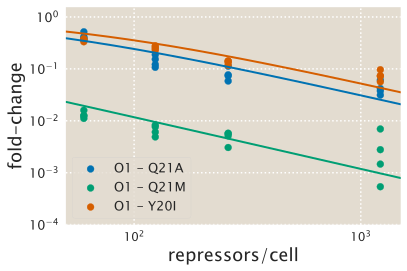

In [76]:
# Define repressor range
rep = np.logspace(0, 4, 200)

# Loop through each operator, compute theoretical fold-change and plot 
# theory and experiment
for group, data in df_group:
    # Computetheoretical fold-change
    fc_thry = fold_change(rep, epsilon_opt['_'.join(group)])
    # Plot theory
    plt.plot(rep, fc_thry)
    # Define label for plot
    label = ' - '.join(group)
    # Plot experiment
    plt.scatter(data.repressors, data.fold_change, label=label)
    
    
plt.xscale('log')
plt.yscale('log')
plt.xlim([50, 1500])
plt.ylim(bottom=1E-4)
plt.legend()
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')

    

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


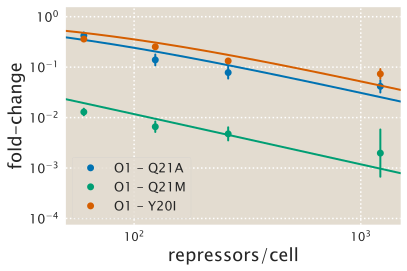

In [77]:
# Set colors for each of the strains
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize counter
j = 0
# Loop through each data set computing the mean and error bars
for group, data in df_group:
    # Computetheoretical fold-change
    fc_thry = fold_change(rep, epsilon_opt['_'.join(group)])
    # Plot theory
    plt.plot(rep, fc_thry, color=colors[j], label='')
    # Get the log of the fold-change
    data['log_fc'] = np.log10(data.fold_change)
    # Compute mean and standard deviation in log scale
    logfc_mean = data.groupby('repressors', sort=True).log_fc.mean().values
    logfc_std = data.groupby('repressors', sort=True).log_fc.std().values
    # Set the +/- values for the error bars
    fc_err = logfc_mean + logfc_std
    fc_err = np.vstack([fc_err,
             logfc_mean - logfc_std])
    # Define label for plot
    label = ' - '.join(group)
    # Plot the mean value
    plt.plot(np.sort(data.repressors.unique()), 10**logfc_mean,
             marker='o', lw=0, color=colors[j], label=label)
    # Plot the error bars as lines in linear scale with the error computed
    # in log scale (trick that took me forever to figure out)
    for i, m in enumerate(logfc_mean):
        plt.plot([np.sort(data.repressors.unique())[i]]  * 2, 
                 10**fc_err[:, i], color=colors[j], label='')
    # increase counter
    j += 1

plt.xscale('log')
plt.yscale('log')
plt.xlim([50, 1500])
plt.legend()
plt.xlabel('repressors/cell')
plt.ylabel('fold-change')

    

# Computing an error bar for the binding energies.

In order to assign an error bar to the energy fits we will use what is known as the Gaussian approximation of the posterior. This approximations consist on the following: Given the log of the posterior distribution
$$
\L(\era) \equiv \ln P(\era \mid D)
\tag{12}
$$
we Taylor expand it up to second order around the most probable energy value $\era^*$ giving
$$
\L \approx \L \rvert_{\era^*} + 
{d\L \over d\era}\rvert_{\era^*} \left( \era^* - \era \right) + 
{1 \over 2} {d^2\L \over d\era^2}\rvert_{\era^*} \left( \era^* - \era \right)^2.
\tag{13}
$$

The second term on Eq. 13 is zero at the peak of the log posterior distribution. That means that when we exponentiate back the log posterior we find
$$
P(\era \mid D) \approx C_o \exp\left[ {1 \over 2} {d^2\L \over d\era^2}\rvert_{\era^*} \left( \era^* - \era \right)^2  \right],
\tag{14}
$$
where $C_o$ is a constant. By inspection we can see that this resembles a lot a Gaussian distribution with the variance being given by
$$
\sigma^2 = - \left( {d^2\L \over d\era^2}\rvert_{\era^*} \right)^{-1}
\tag{15}
$$
This implies that if we can evaluate the second derivative at the peak of the log posterior distribution we will get the desired error bar for our parameter estimation!

Let's then compute this second derivative. We re-define the `log_posterior_ra` function to take the experimental fold-change and the repressor copy number as independent parameters in order to make the hessian function to work.

In [13]:
def log_post(epsilon_ra, fc_exp, R):
    '''
    Computes the unormalized log posterior for the repressor-DNA binding energy 
    given a Gaussian likelihood and a uniform prior for the binding energy.
    Parameters
    ----------
    epsilon_ra : float.
        Repressor-DNA binding energy to be evaluated in units of kBT.
    data : array-like, shape n x 2
        data[:, 0] : experimental fold-change values.
        data[:, 1] : associated repressor copy numbers.
    Returns
    -------
    non-normalized log-posterior probability.
    '''
    # Compute theoretical fold-change
    fc_thry = fold_change(R, epsilon_ra)
    
    # Compute the log-posterior
    return -len(R) / 2 * np.log(np.sum((fc_exp - fc_thry)**2))

In [50]:
# Group data by operator and binding mutant
df_group = df.groupby(['operator', 'strain'])

# Initialize dictionary to save the error bar for the energy for each strain
# epsilon_error = np.zeros(len(df_group))
epsilon_error = {}

# Initialize counter
j = 0
# Loop through each of the groups and compute the second derivative numerically
for group, data in df_group:
    print(group)
    # Extract the fold-change and repressor copy number from the data
    vals = data[['fold_change', 'repressors']].values
    args = (vals[:,0], vals[:,1])
    # Compute the second derivative
    hes = smnd.approx_hess(epsilon_opt['_'.join(group)],
                           log_post, args=args)
    epsilon_error['_'.join(group)] = np.sqrt(- 1 / hes)[0]
    print(epsilon_error['_'.join(group)].round(3))
    # increase counter
    j += 1

('O1', 'Q21A')
[ 0.1]
('O1', 'Q21M')
[ 0.074]
('O1', 'Y20I')
[ 0.051]


# Testing these energies with the IPTG titration data.

Now that we have an estimate of the binding energies, let's use this parameter along with the dissociation constants inferred in previous work to see if this single parameter change explains the change in the induction profile.

First we need to read the titration data.

In [71]:
# Read the data
df_iptg = pd.read_csv('../../data/flow_master.csv', index_col=0)
# Remove the auto and delta values
df_iptg = df_iptg[(df_iptg.operator == 'O1') & (df_iptg.date > 20170701)]
df_iptg = df_iptg[(df_iptg.strain != 'auto') & (df_iptg.strain != 'delta')]
df_iptg.head()

,IPTG_uM,mut_class,date,fold_change,mean_YFP,mean_YFP_bgcorr,operator,pseudo_fold_change,repressors,strain,username
24,0.1,dna,20170710,0.061469,3755.702949,716.529211,O1,NaN,260,Q21A,mrazomej
25,0.0,dna,20170710,0.071182,3808.350551,747.353077,O1,NaN,260,Q21A,mrazomej
26,1000.0,dna,20170710,0.941868,14138.649498,11050.356053,O1,NaN,260,Q21A,mrazomej
27,100.0,dna,20170710,0.667062,11920.328087,8831.881108,O1,NaN,260,Q21A,mrazomej
28,10.0,dna,20170710,0.127802,4473.242265,1457.497111,O1,NaN,260,Q21A,mrazomej


Now we can use the parameters infered with the lacI titration to look at the IPTG titration curves.

Let's first define the parameters needed for the theoretical predictions.

In [78]:
# Define the energies from the wt as inferred by Garcia & Phillips
energies = {'O1_wt': -15.3, 'O2_wt': -13.9, 'O3_wt': -9.7, 'Oid_wt': -17}

# Combine dictinaries to have all binding energies together
epsilon_opt = {**epsilon_opt, **energies}

# Define dissociation constants for the WT
ka = -np.log(139.59)
ki = -np.log(0.53)

Now let's plot the predictions and the data.

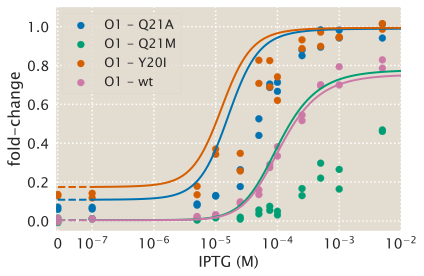

In [79]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 100)
IPTG_lin = np.array([0, 1E-7])

# Group data by operator and binding mutant
df_group = df_iptg.groupby(['operator', 'strain'])

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Initialize figure
plt.figure()

# initialize counter
j = 0

# Loop through strains plotting predicitons and data
for group, data in df_group:
    # Plot theoretical prediction
    # Log scale
    plt.plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
        ka=ka, ki=ki, epsilon=4.5,
        R=data.repressors.unique()[0],
        epsilon_RA=epsilon_opt['_'.join(group)]),
        color=colors[j], label=None)
    # Linear scale
    plt.plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
        ka=ka, ki=ki, epsilon=4.5,
        R=data.repressors.unique()[0],
        epsilon_RA=epsilon_opt['_'.join(group)]),
        linestyle='--', color=colors[j], label=None)
    # Plot data
    plt.scatter(data.IPTG_uM / 1E6, data.fold_change, label=' - '.join(group),
               color=colors[j])
    # increase counter
    j +=1

plt.xscale('symlog', linthreshx=1E-7, linscalex=0.5)
plt.xlabel('IPTG (M)', fontsize=15)
plt.ylabel('fold-change', fontsize=16)
plt.ylim([-0.05, 1.1])
plt.xlim([-5E-9, np.max(IPTG)])
plt.legend(loc='upper left')
plt.tick_params(labelsize=14)
plt.tight_layout()
